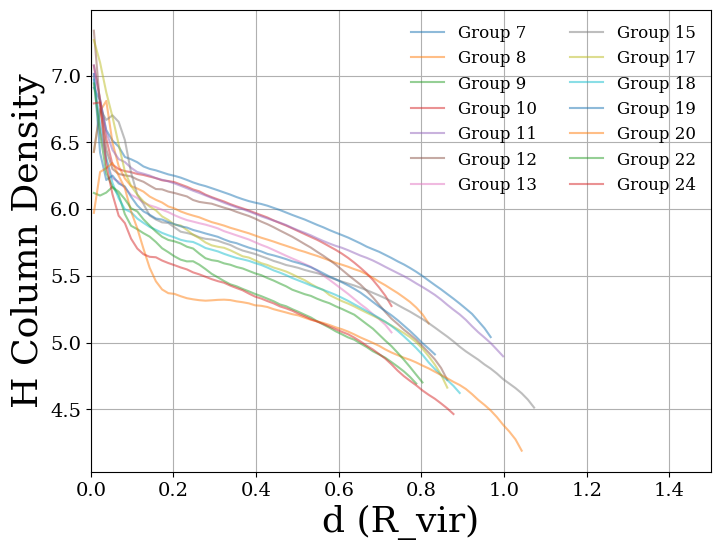

/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_6550/2648052419.py:86: RuntimeWarning: Mean of empty slice
  mean_profile = np.nanmean(all_profiles, axis=0)
/Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/igrm/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


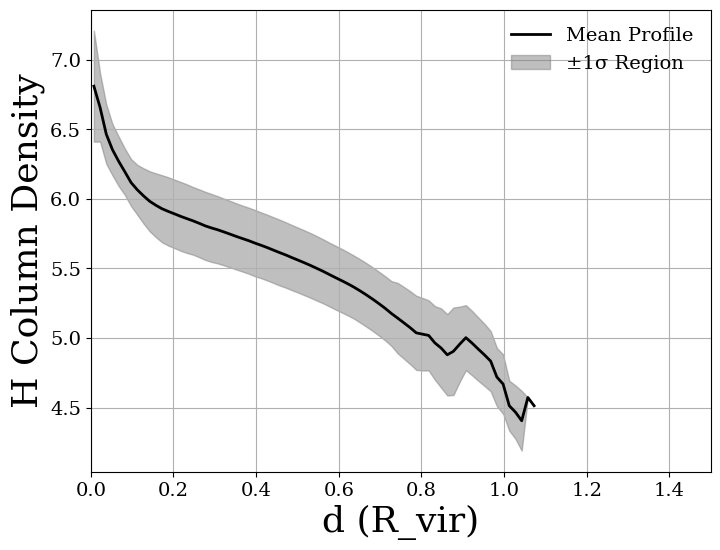

In [18]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({"text.usetex": False})

# Define the directory where H maps are stored
h_map_dir = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/TNG50_fitting_results/h_maps"

# File containing group information
group_info_file = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/TNG50_fitting_results/TNG_halos.txt"

# Read the group information
df = pd.read_csv(group_info_file, sep="|", comment="#", skipinitialspace=True)
df.columns = df.columns.str.strip()  # Remove any unwanted spaces in column names

# Extract required group parameters
group_ids = df["Grp_Index"].tolist()

# Define radial bins in units of R_vir (from 0 to 1.5 R_vir)
num_bins = 100
radii_bins = np.linspace(0, 1.5, num_bins + 1)

# Store the computed radial profiles from each group
all_profiles = []

# Initialize the first plot (individual group profiles)
plt.figure(figsize=(8, 6))

# Process each group's H map
for group_id in group_ids:
    file_path = os.path.join(h_map_dir, f"grid_halo_TNG50-1_91_{group_id}.hdf5")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    with h5py.File(file_path, "r") as f:
        if "grid" in f:  # Check if dataset exists
            h_map = f["grid"][:]  # Use the dataset named "grid"
        else:
            print(f"Dataset 'grid' not found in {file_path}")
            continue

    # The grid covers 4 R_vir (i.e., from -2 to +2 R_vir)
    npix = h_map.shape[0]        # e.g. 3000 pixels
    center = npix // 2           # Center pixel index
    pixel_size = 4 / npix        # Each pixel corresponds to this many R_vir

    # Create a 2D coordinate grid (in units of R_vir)
    y, x = np.indices(h_map.shape)
    r_grid = np.sqrt((x - center)**2 + (y - center)**2) * pixel_size

    # Compute the azimuthally averaged hydrogen content in annuli between 0 and 1.5 R_vir
    mean_h_values = []
    for i in range(len(radii_bins) - 1):
        mask = (r_grid >= radii_bins[i]) & (r_grid < radii_bins[i + 1])
        if np.sum(mask) > 0:
            mean_h_values.append(np.mean(h_map[mask]))
        else:
            mean_h_values.append(np.nan)

    # Save the computed profile for later analysis
    all_profiles.append(mean_h_values)

    # Compute bin midpoints (in R_vir units) for plotting
    bin_midpoints = 0.5 * (radii_bins[:-1] + radii_bins[1:])

    # Plot the profile for this group
    plt.plot(bin_midpoints, mean_h_values, alpha=0.5, label=f"Group {group_id}")

# Customize the first plot (individual profiles)
plt.xlabel("d (R_vir)", fontsize=26)
plt.ylabel("H Column Density", fontsize=26)
#plt.title("Radial Profiles of Hydrogen (0 to 1.5 R_vir)")
plt.xlim(0, 1.5)   # Force x-axis from 0 to 1.5 R_vir
plt.legend(frameon=False, fontsize=12, ncol=2)
plt.grid()
plt.show()

# Convert collected profiles to a NumPy array for further analysis
all_profiles = np.array(all_profiles, dtype=np.float64)

# For each radial bin, compute the mean and standard deviation (ignoring NaNs)
mean_profile = np.nanmean(all_profiles, axis=0)
std_profile = np.nanstd(all_profiles, axis=0)

# Compute bin midpoints (in R_vir units) for the radial bins we used (0 to 1.5)
bin_midpoints = 0.5 * (radii_bins[:-1] + radii_bins[1:])

# Second plot: Mean profile with ±1σ shaded region
plt.figure(figsize=(8, 6))
plt.plot(bin_midpoints, mean_profile, color='black', linewidth=2, label="Mean Profile")
plt.fill_between(bin_midpoints, mean_profile - std_profile, mean_profile + std_profile, 
                 color='gray', alpha=0.5, label="±1σ Region")
plt.xlabel("d (R_vir)", fontsize=26)
plt.ylabel("H Column Density", fontsize=26)
# plt.title("Mean Radial Hydrogen Profile (0 to 1.5 R_vir)")
plt.xlim(0, 1.5)   # Set x-axis limit explicitly
plt.legend(frameon=False)
plt.grid()

# Disable LaTeX text rendering to avoid Unicode issues
plt.rcParams.update({"text.usetex": False})
plt.show()

7 188893 13.54
8 199226 13.42
9 208563 13.17
10 219842 13.44
11 231369 13.42
12 239843 13.38
13 247945 13.31
15 264620 13.21
17 277688 13.19
18 283512 13.21
19 288932 13.18
20 294515 12.97
22 305020 13.16
24 313950 12.97


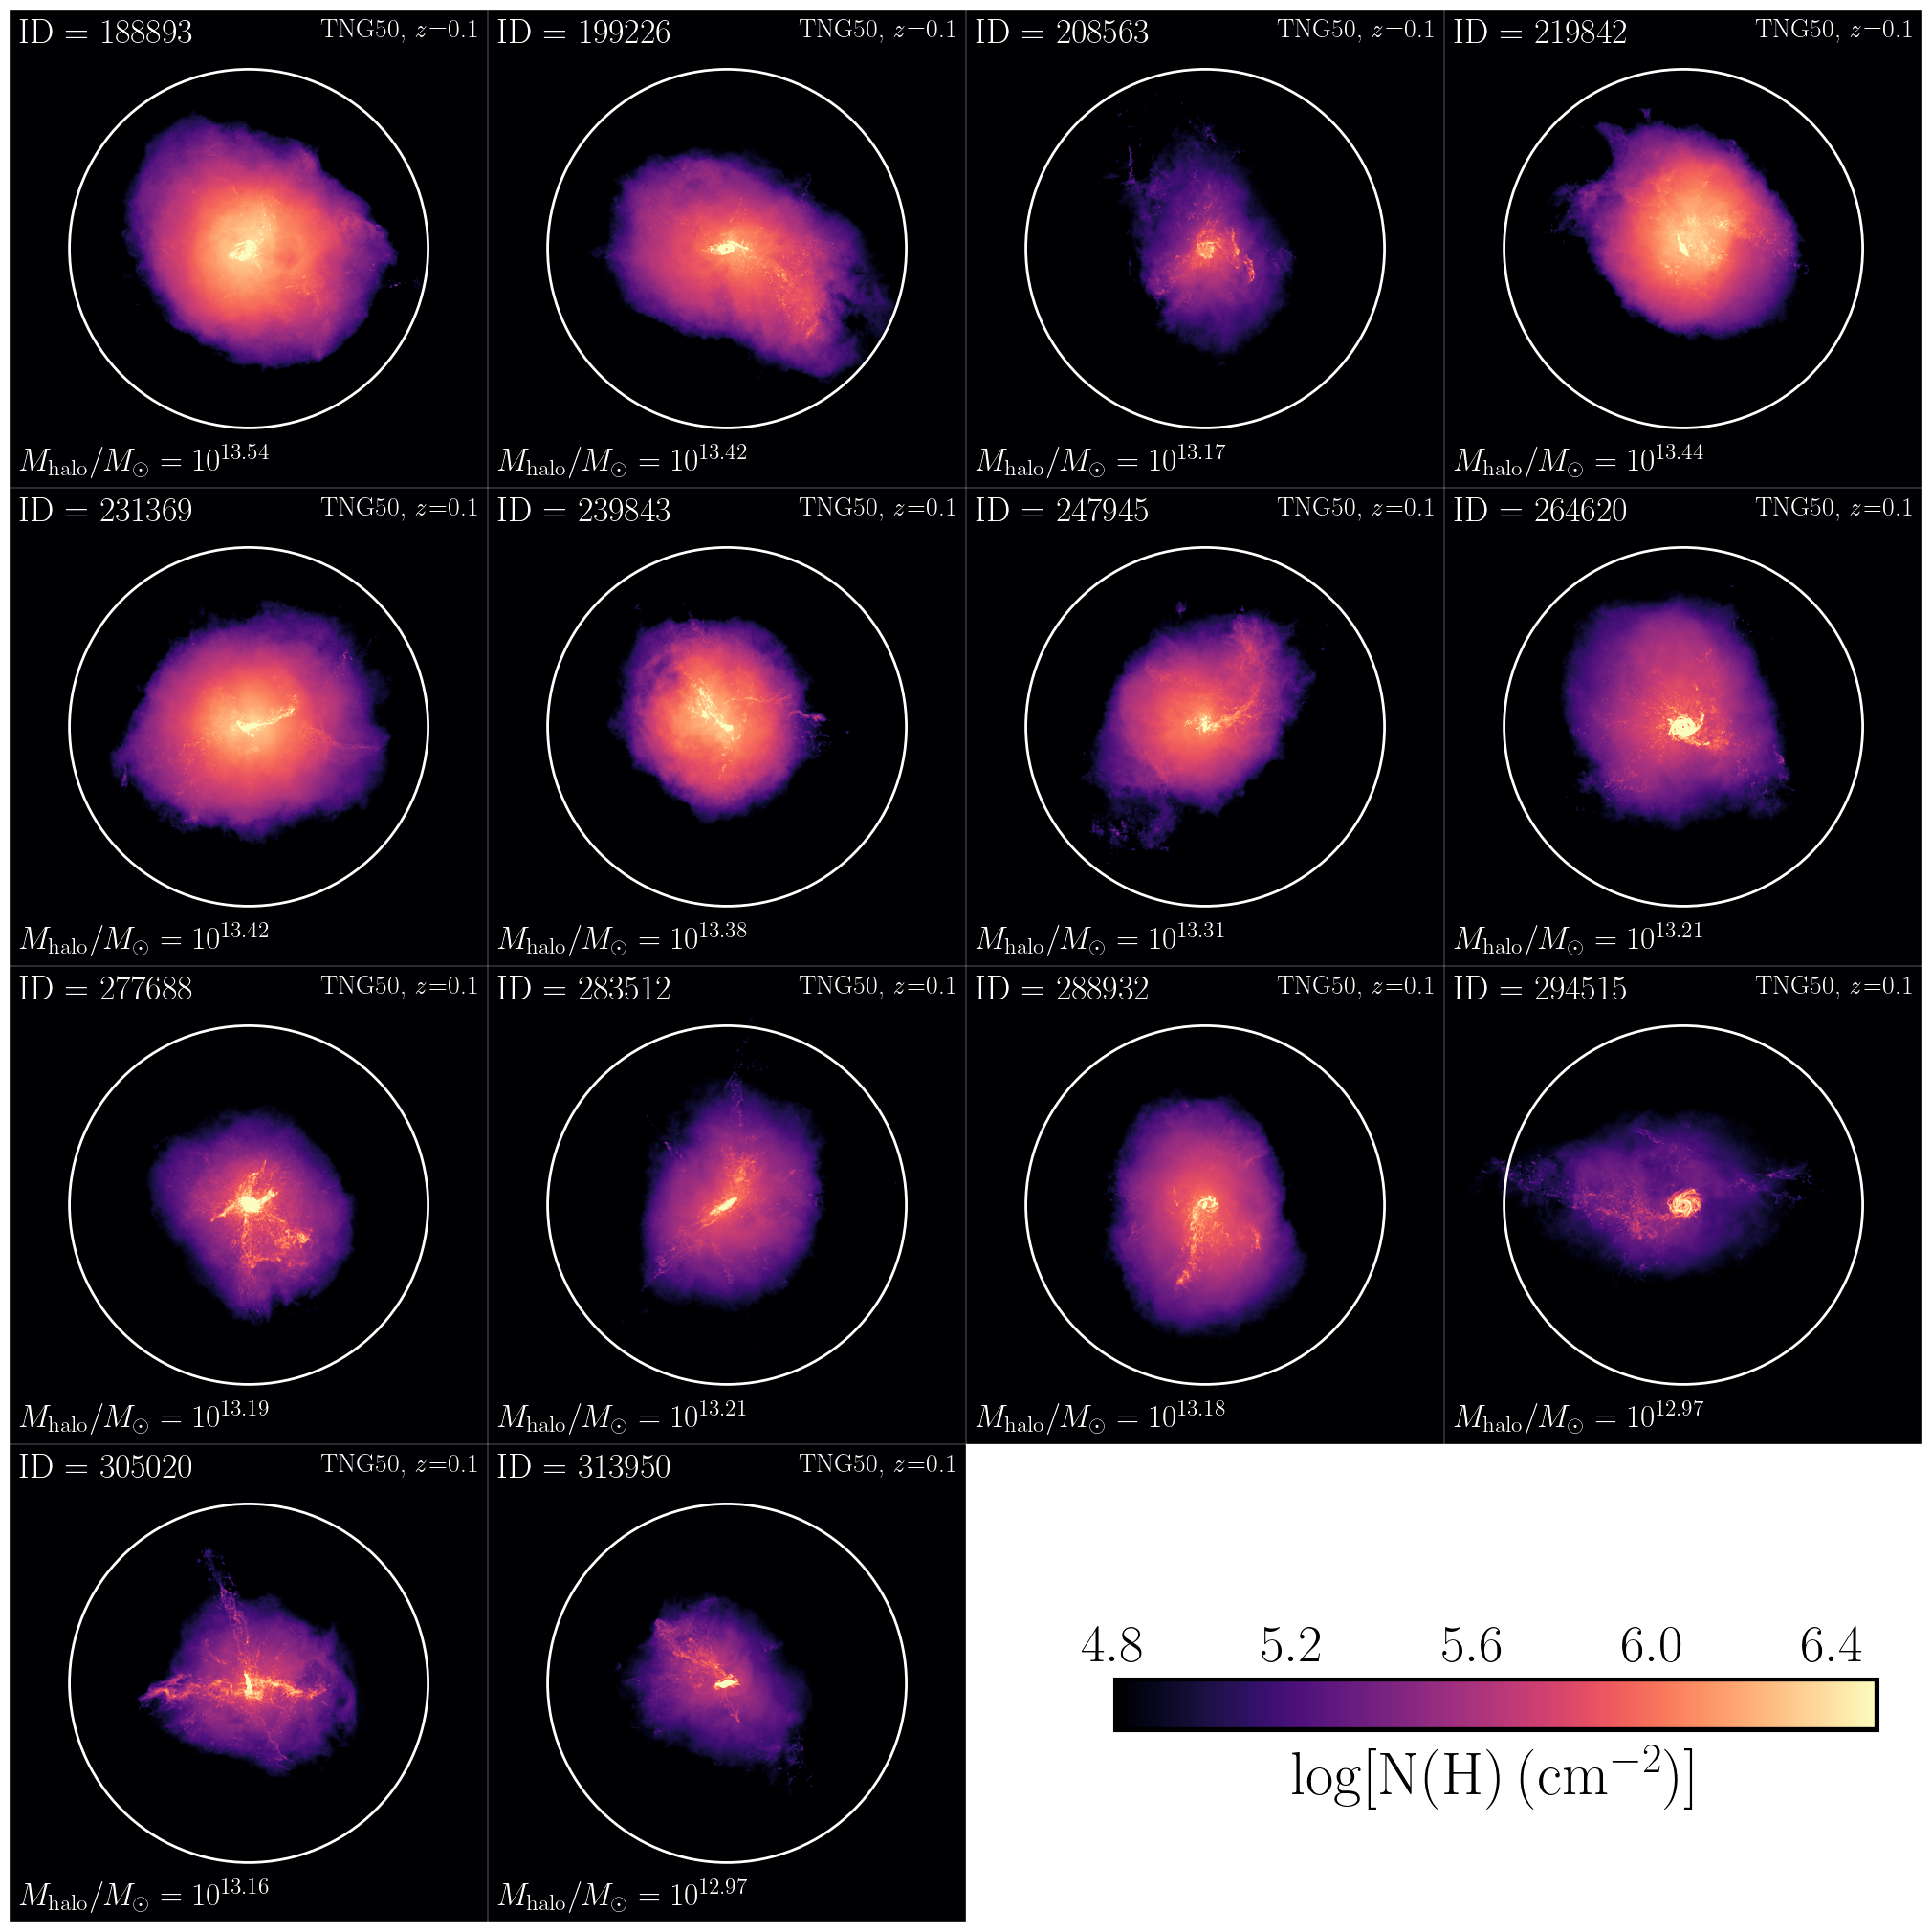

In [14]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib import rcParams
import pandas as pd
import os

# Configure matplotlib for LaTeX rendering
rcParams["text.usetex"] = True
rcParams["font.family"] = "serif"
rcParams["font.size"] = 14

# File containing the group information
group_file_path = "../TNG50_fitting_results/TNG_halos.txt"

# Directory containing HDF5 files
input_dir = "../TNG50_fitting_results/h_maps"

# Read group information from the file
group_data = pd.read_csv(group_file_path, sep="|", skipinitialspace=True)
group_data.columns = group_data.columns.str.strip()  # Strip column names

# Extract necessary columns
groups = group_data[["Grp_Index", "GroupFirstSub", "M_Crit200_log"]].rename(
    columns={"Grp_Index": "halo_id", "GroupFirstSub": "group_first_sub", "M_Crit200_log": "mass"}
)
groups["mass"] = groups["mass"].astype(float)
groups["halo_id"] = groups["halo_id"].astype(int)
groups["group_first_sub"] = groups["group_first_sub"].astype(int)

# Visualization parameters
colormap = "magma"
vmin = 4.8  # Minimum value for the color scale
vmax = 6.5  # Maximum value for the color scale

# Create a figure for the combined plot
ncols = 4  # Number of columns
nrows = 4  # Number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

# Adjust spacing between subplots to eliminate all gaps
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
axes = axes.flatten()

# Loop over each group and create a subplot
for i, row in groups.iterrows():
    halo_id = row["halo_id"]
    group_first_sub = row["group_first_sub"]  # GroupFirstSub value
    halo_mass = round(row["mass"], 2)  # Logarithmic mass value with two decimals

    halo_id = int(halo_id)  
    group_first_sub = int(group_first_sub)
    # use only two decimal places for mass
    halo_mass = round(halo_mass, 2)
    print(halo_id, group_first_sub, halo_mass)
    
    # Load the HDF5 file
    file_path = f"{input_dir}/grp_{halo_id}_halo_{halo_id}_snapshot_91.hdf5"
    file_path = f"{input_dir}/grid_halo_TNG50-1_91_{halo_id}.hdf5"
    with h5py.File(file_path, "r") as hdf:
        if "grid" in hdf:
            data = hdf["grid"][()]
        else:
            print(f"Dataset 'grid' not found in {file_path}")
            continue

    # Mask NaN values
    data = np.nan_to_num(data, nan=vmin)

    # Plot the data
    ax = axes[i]
    im = ax.imshow(data, origin="lower", cmap=colormap, vmin=vmin, vmax=vmax)

    # Remove axis ticks and labels
    ax.axis("off")

    # Draw boundary lines
    rect = Rectangle(
        (0, 0),
        data.shape[1],
        data.shape[0],
        linewidth=0.25,
        edgecolor="white",
        facecolor="none",
    )
    ax.add_patch(rect)

    # Add text annotations
    ax.text(
        0.02, 0.98, f"ID = {group_first_sub}",  # GroupFirstSub on the top-left corner
        transform=ax.transAxes, color="white", fontsize=26, ha="left", va="top", weight="bold")
        
    ax.text(
        0.98, 0.98, r"TNG50, \textit{z}=0.1",
        transform=ax.transAxes, color="white", fontsize=20, ha="right", va="top", weight="bold"
    )
    ax.text(
        0.02, 0.02, r"$M_{\rm halo} / M_\odot = 10^{" + f"{halo_mass:.2f}" + r"}$",
        transform=ax.transAxes, color="white", fontsize=24, ha="left", va="bottom", weight="bold"
    )

    # Add a circle at the center
    center = (data.shape[1] / 2, data.shape[0] / 2)  # (x, y) center
    radius = 1.5 / 4 * data.shape[1]  # Radius in pixels
    circle = Circle(center, radius, color="white", fill=False, linewidth=2)
    ax.add_patch(circle)
    
    # code for plotting the 3* half mass radius circles for the member galaxies of the group 




# Hide the last two unused subplots
for j in range(len(groups), len(axes) - 2):
    fig.delaxes(axes[j])

# Hide the last two unused subplots
for j in range(len(groups), len(axes)):
    axes[j].axis("off")  # Turn off the axis for the unused subplots
# Define the position for the colorbar spanning the last two subplots
cbar_ax = fig.add_axes([
    0.577,  # x-coordinate (centered over the last two subplots)
    0.1,   # y-coordinate
    0.40,   # width (spanning the two subplots)
    0.028    # height (small horizontal bar)
])

# cbar_ticks = [11, 12, 13, 14, 15, 16]  # Custom ticks for the colorbar
cbar_ticks = [4.8, 5.2, 5.6, 6.0, 6.4]  # Custom ticks for the colorbar

# Add the colorbar
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal", ticks=cbar_ticks, aspect=10, pad=0.23, fraction=0.046)
cbar.set_label(r'$\log[\mathrm{N(H)} \, (\mathrm{cm^{-2}})]$', fontsize=46, labelpad=10, weight='bold')

# Increase the font size of the tick labels and remove ticks
# Improve tick label appearance
cbar.ax.tick_params(labelsize=40, length=0, width=0,direction = 'in',zorder = 10)  # Hide ticks but keep labels bold
cbar.ax.xaxis.set_ticks_position('top')  # Move tick labels above the colorbar

cbar.outline.set_edgecolor('black',
                           )  # Set the color of the colorbar outline to black

# Move the tick labels inside the colorbar
for label in cbar.ax.get_xticklabels():
    label.set_verticalalignment('center')  # Align labels vertically at the center
    label.set_position((0, +1.45))  # Move labels inside the bar

# Add a black border around the colorbar
rect = Rectangle(
    (0, 0),  # Bottom-left corner of the colorbar (normalized coordinates)
    1, 1,    # Width and height of the rectangle in normalized coordinates
    transform=cbar_ax.transAxes, edgecolor="black", facecolor="none", linewidth=6
)
cbar_ax.add_patch(rect)

# Save the final figure
output_file = "H_2D_maps.pdf"
output_dir = "../TNG50_fitting_results/Plots_gal_removed"
output_file = os.path.join(output_dir, output_file)
plt.savefig(output_file, dpi=200, bbox_inches="tight")
plt.show()

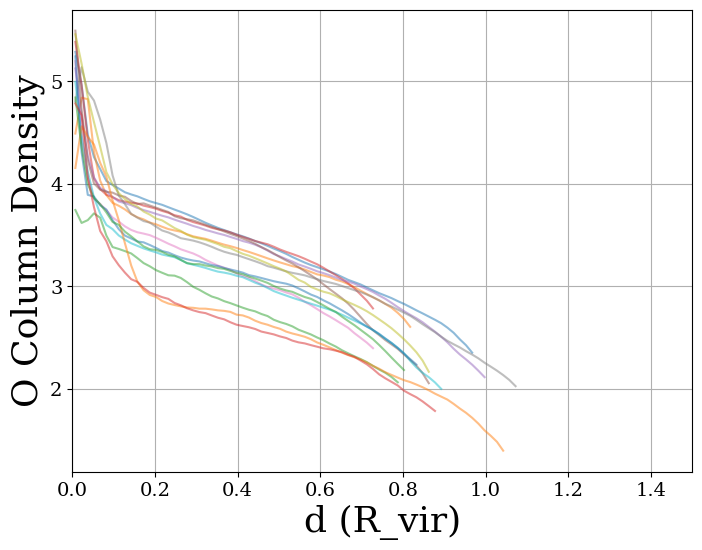

/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_6550/3862937211.py:84: RuntimeWarning: Mean of empty slice
  mean_profile = np.nanmean(all_profiles, axis=0)
/Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/igrm/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


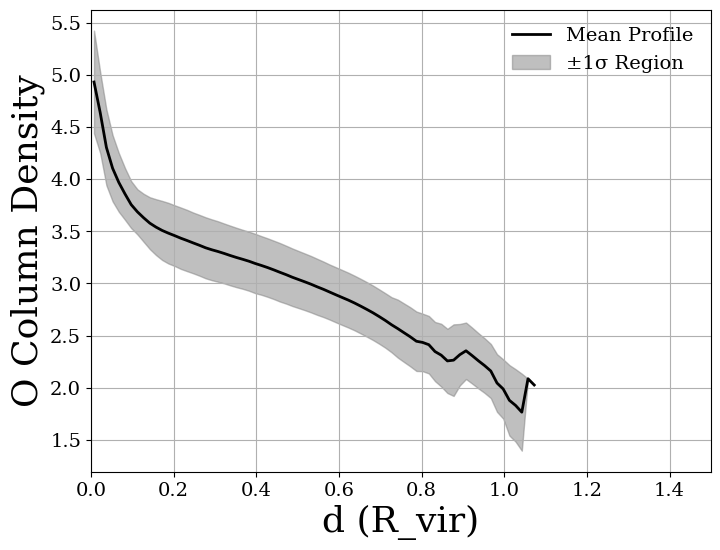

In [19]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({"text.usetex": False})
# Define the directory where H maps are stored
h_map_dir = "../TNG50_fitting_results/o_maps"

# File containing group information
group_info_file = "../TNG50_fitting_results/TNG_halos.txt"

# Read the group information
df = pd.read_csv(group_info_file, sep="|", comment="#", skipinitialspace=True)
df.columns = df.columns.str.strip()  # Remove any unwanted spaces in column names

# Extract required group parameters
group_ids = df["Grp_Index"].tolist()

# Define radial bins in units of R_vir (from 0 to 1.5 R_vir)
num_bins = 100
radii_bins = np.linspace(0, 1.5, num_bins + 1)

# Store the computed radial profiles from each group
all_profiles = []

# Initialize the first plot (individual group profiles)
plt.figure(figsize=(8, 6))

# Process each group's H map
for group_id in group_ids:
    file_path = os.path.join(h_map_dir, f"grid_halo_TNG50-1_91_{group_id}.hdf5")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue

    with h5py.File(file_path, "r") as f:
        if "grid" in f:  # Check if dataset exists
            h_map = f["grid"][:]  # Use the dataset named "grid"
        else:
            print(f"Dataset 'grid' not found in {file_path}")
            continue

    # The grid covers 4 R_vir (i.e., from -2 to +2 R_vir)
    npix = h_map.shape[0]        # e.g. 3000 pixels
    center = npix // 2           # Center pixel index
    pixel_size = 4 / npix        # Each pixel corresponds to this many R_vir

    # Create a 2D coordinate grid (in units of R_vir)
    y, x = np.indices(h_map.shape)
    r_grid = np.sqrt((x - center)**2 + (y - center)**2) * pixel_size

    # Compute the azimuthally averaged hydrogen content in annuli between 0 and 1.5 R_vir
    mean_h_values = []
    for i in range(len(radii_bins) - 1):
        mask = (r_grid >= radii_bins[i]) & (r_grid < radii_bins[i + 1])
        if np.sum(mask) > 0:
            mean_h_values.append(np.mean(h_map[mask]))
        else:
            mean_h_values.append(np.nan)

    # Save the computed profile for later analysis
    all_profiles.append(mean_h_values)

    # Compute bin midpoints (in R_vir units) for plotting
    bin_midpoints = 0.5 * (radii_bins[:-1] + radii_bins[1:])

    # Plot the profile for this group
    plt.plot(bin_midpoints, mean_h_values, alpha=0.5, label=f"Group {group_id}")

# Customize the first plot (individual profiles)
plt.xlabel("d (R_vir)",fontsize=26)
plt.ylabel("O Column Density",fontsize=26)

plt.xlim(0, 1.5)   # Force x-axis from 0 to 1.5 R_vir
plt.grid()
plt.show()

# Convert collected profiles to a NumPy array for further analysis
all_profiles = np.array(all_profiles, dtype=np.float64)

# For each radial bin, compute the mean and standard deviation (ignoring NaNs)
mean_profile = np.nanmean(all_profiles, axis=0)
std_profile = np.nanstd(all_profiles, axis=0)

# Compute bin midpoints (in R_vir units) for the radial bins we used (0 to 1.5)
bin_midpoints = 0.5 * (radii_bins[:-1] + radii_bins[1:])

# Second plot: Mean profile with ±1σ shaded region
plt.figure(figsize=(8, 6))
plt.plot(bin_midpoints, mean_profile, color='black', linewidth=2, label="Mean Profile")
plt.fill_between(bin_midpoints, mean_profile - std_profile, mean_profile + std_profile, 
                 color='gray', alpha=0.5, label="±1σ Region")
plt.xlabel("d (R_vir)",fontsize=26)
plt.ylabel("O Column Density",fontsize=26)
# plt.title("Mean Radial Hydrogen Profile (0 to 1.5 R_vir)")
plt.xlim(0, 1.5)   # Set x-axis limit explicitly
plt.legend(frameon=False)
plt.grid()

# Disable LaTeX text rendering to avoid Unicode issues
plt.rcParams.update({"text.usetex": False})
plt.show()

7 188893 13.54
8 199226 13.42
9 208563 13.17
10 219842 13.44
11 231369 13.42
12 239843 13.38
13 247945 13.31
15 264620 13.21
17 277688 13.19
18 283512 13.21
19 288932 13.18
20 294515 12.97
22 305020 13.16
24 313950 12.97


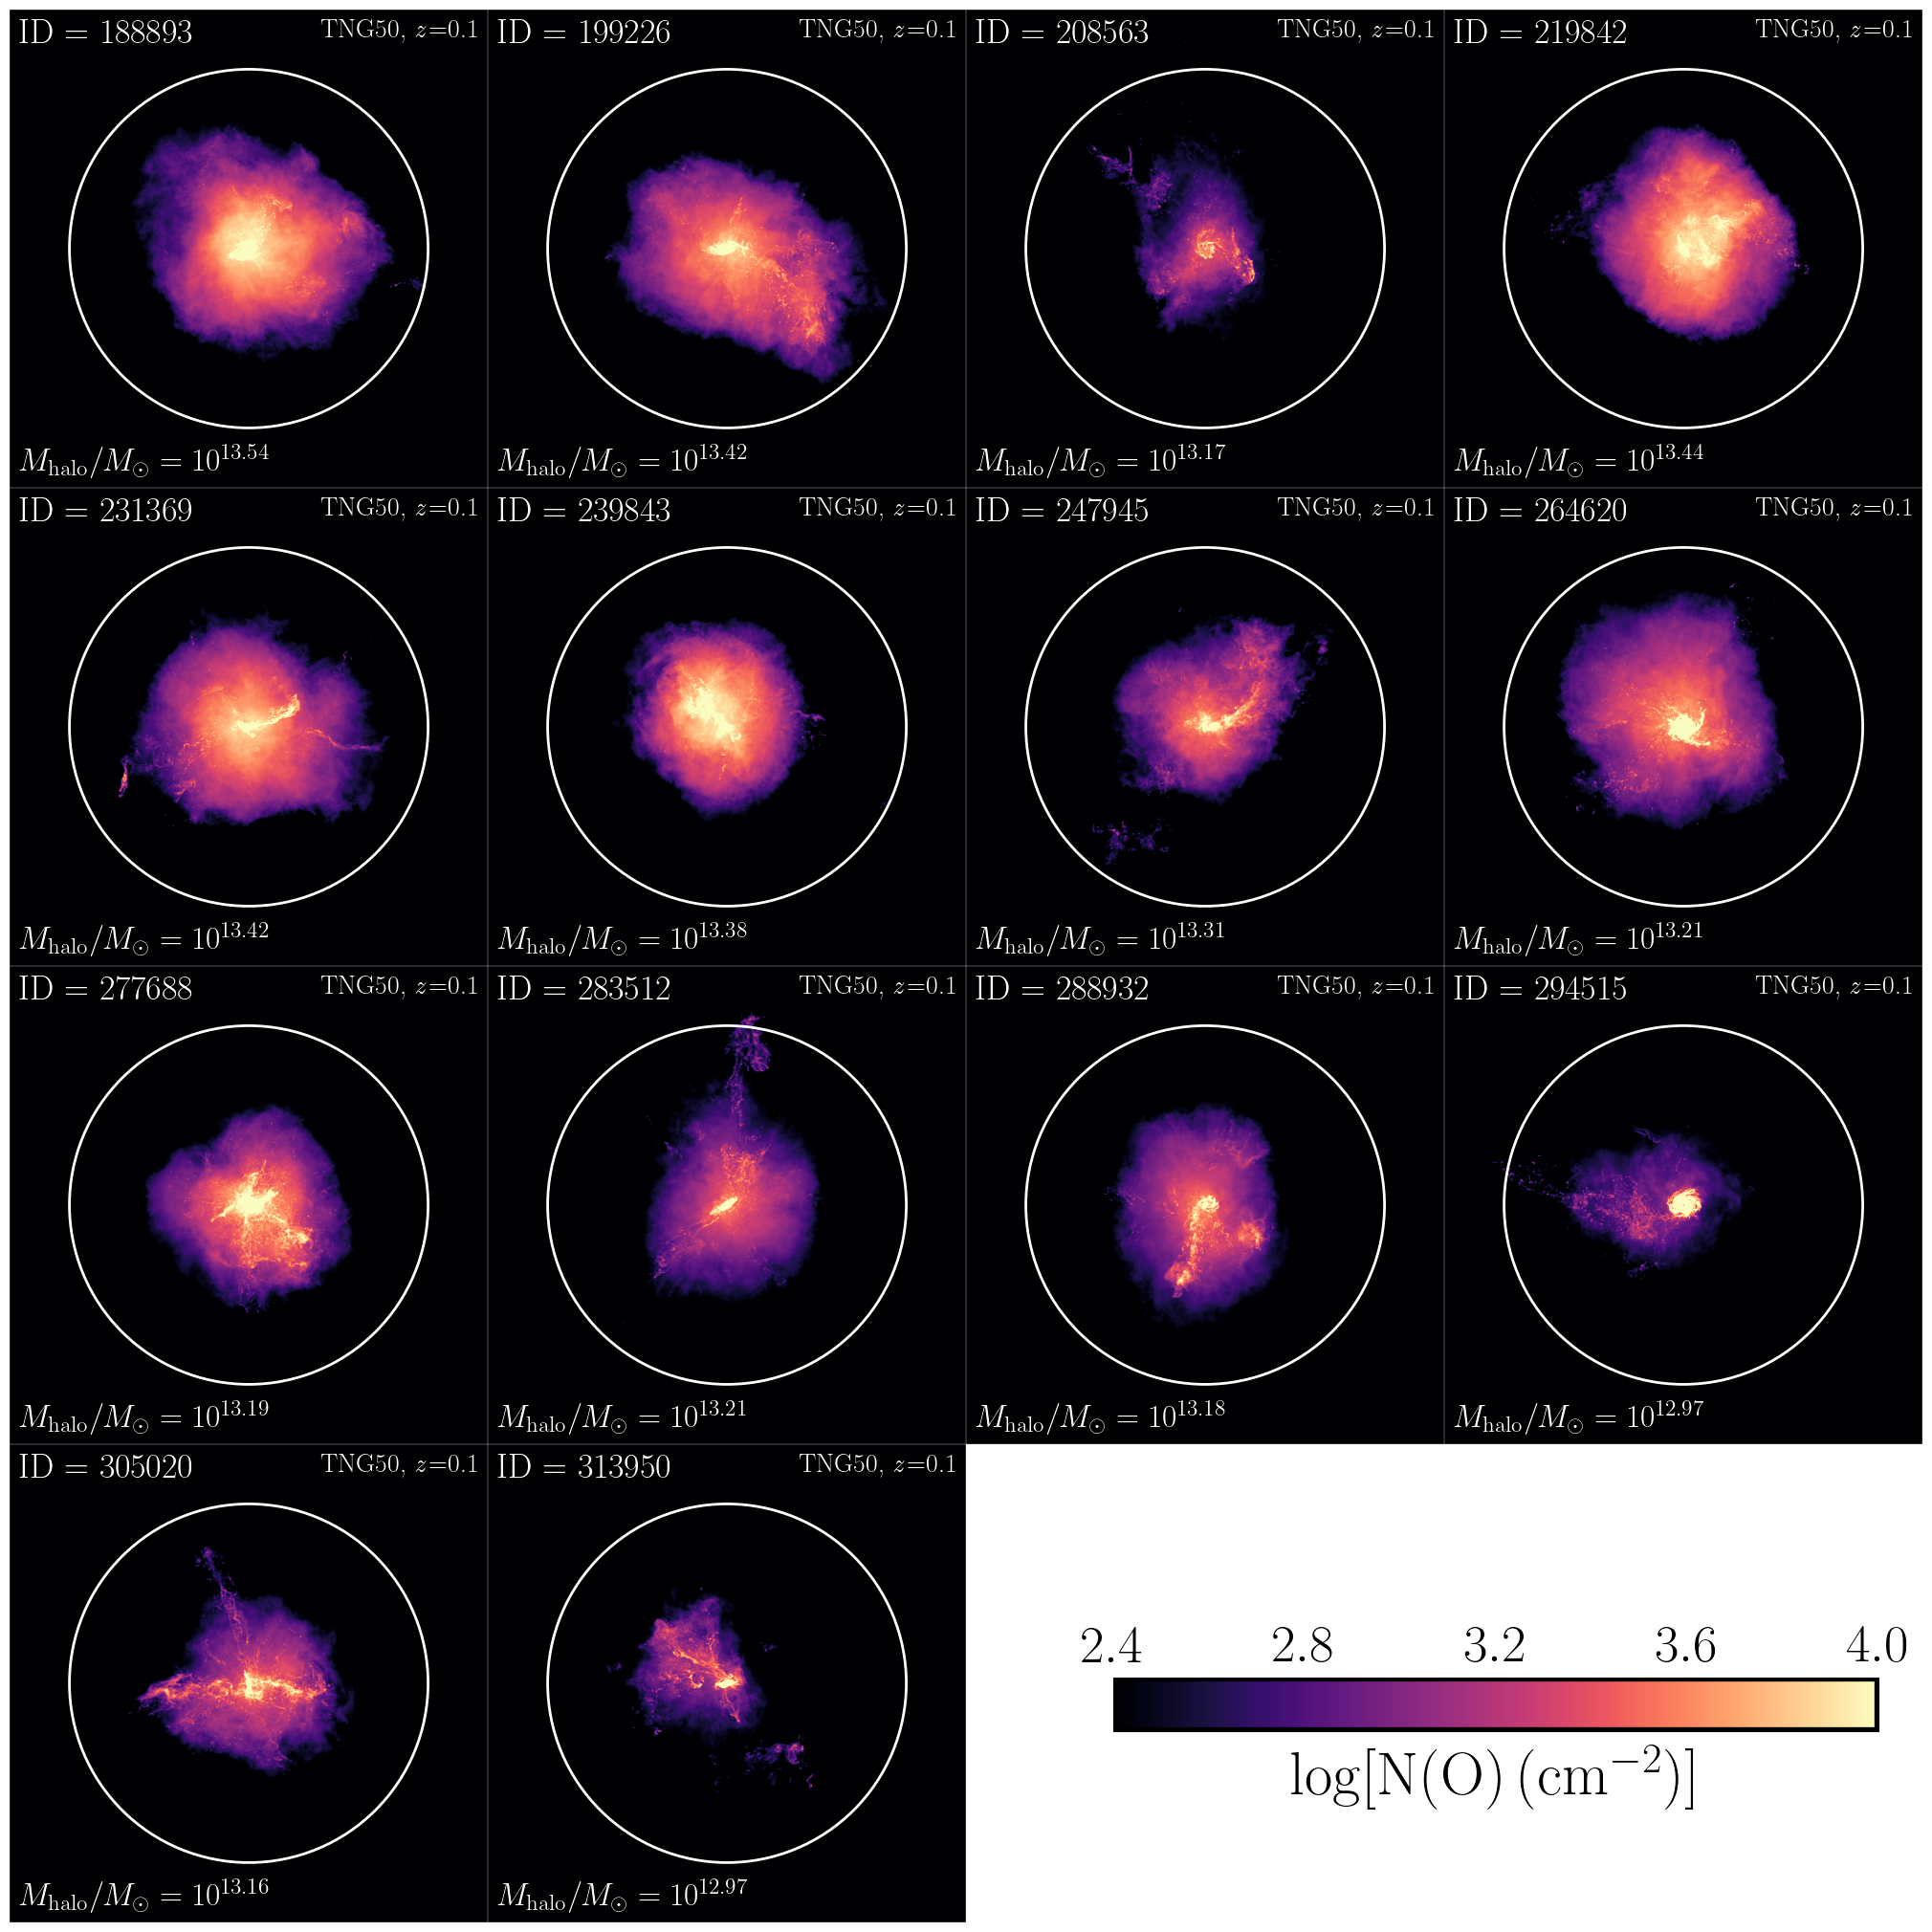

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib import rcParams
import pandas as pd
import os

# Configure matplotlib for LaTeX rendering
rcParams["text.usetex"] = True
rcParams["font.family"] = "serif"
rcParams["font.size"] = 14

# File containing the group information
group_file_path = "../TNG50_fitting_results/TNG_halos.txt"

# Directory containing HDF5 files
input_dir = "../TNG50_fitting_results/o_maps"

# Read group information from the file
group_data = pd.read_csv(group_file_path, sep="|", skipinitialspace=True)
group_data.columns = group_data.columns.str.strip()  # Strip column names

# Extract necessary columns
groups = group_data[["Grp_Index", "GroupFirstSub", "M_Crit200_log"]].rename(
    columns={"Grp_Index": "halo_id", "GroupFirstSub": "group_first_sub", "M_Crit200_log": "mass"}
)
groups["mass"] = groups["mass"].astype(float)
groups["halo_id"] = groups["halo_id"].astype(int)
groups["group_first_sub"] = groups["group_first_sub"].astype(int)

# Visualization parameters
colormap = "magma"
vmin = 2.4  # Minimum value for the color scale
vmax = 4  # Maximum value for the color scale

# Create a figure for the combined plot
ncols = 4  # Number of columns
nrows = 4  # Number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

# Adjust spacing between subplots to eliminate all gaps
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
axes = axes.flatten()

# Loop over each group and create a subplot
for i, row in groups.iterrows():
    halo_id = row["halo_id"]
    group_first_sub = row["group_first_sub"]  # GroupFirstSub value
    halo_mass = round(row["mass"], 2)  # Logarithmic mass value with two decimals

    halo_id = int(halo_id)  
    group_first_sub = int(group_first_sub)
    # use only two decimal places for mass
    halo_mass = round(halo_mass, 2)
    print(halo_id, group_first_sub, halo_mass)
    
    # Load the HDF5 file
    file_path = f"{input_dir}/grp_{halo_id}_halo_{halo_id}_snapshot_91.hdf5"
    file_path = f"{input_dir}/grid_halo_TNG50-1_91_{halo_id}.hdf5"
    with h5py.File(file_path, "r") as hdf:
        if "grid" in hdf:
            data = hdf["grid"][()]
        else:
            print(f"Dataset 'grid' not found in {file_path}")
            continue

    # Mask NaN values
    data = np.nan_to_num(data, nan=vmin)

    # Plot the data
    ax = axes[i]
    im = ax.imshow(data, origin="lower", cmap=colormap, vmin=vmin, vmax=vmax)

    # Remove axis ticks and labels
    ax.axis("off")

    # Draw boundary lines
    rect = Rectangle(
        (0, 0),
        data.shape[1],
        data.shape[0],
        linewidth=0.25,
        edgecolor="white",
        facecolor="none",
    )
    ax.add_patch(rect)

    # Add text annotations
    ax.text(
        0.02, 0.98, f"ID = {group_first_sub}",  # GroupFirstSub on the top-left corner
        transform=ax.transAxes, color="white", fontsize=26, ha="left", va="top", weight="bold")
        
    ax.text(
        0.98, 0.98, r"TNG50, \textit{z}=0.1",
        transform=ax.transAxes, color="white", fontsize=20, ha="right", va="top", weight="bold"
    )
    ax.text(
        0.02, 0.02, r"$M_{\rm halo} / M_\odot = 10^{" + f"{halo_mass:.2f}" + r"}$",
        transform=ax.transAxes, color="white", fontsize=24, ha="left", va="bottom", weight="bold"
    )

    # Add a circle at the center
    center = (data.shape[1] / 2, data.shape[0] / 2)  # (x, y) center
    radius = 1.5 / 4 * data.shape[1]  # Radius in pixels
    circle = Circle(center, radius, color="white", fill=False, linewidth=2)
    ax.add_patch(circle)
    
    # code for plotting the 3* half mass radius circles for the member galaxies of the group 




# Hide the last two unused subplots
for j in range(len(groups), len(axes) - 2):
    fig.delaxes(axes[j])

# Hide the last two unused subplots
for j in range(len(groups), len(axes)):
    axes[j].axis("off")  # Turn off the axis for the unused subplots
# Define the position for the colorbar spanning the last two subplots
cbar_ax = fig.add_axes([
    0.577,  # x-coordinate (centered over the last two subplots)
    0.1,   # y-coordinate
    0.40,   # width (spanning the two subplots)
    0.028    # height (small horizontal bar)
])

# cbar_ticks = [11, 12, 13, 14, 15, 16]  # Custom ticks for the colorbar
# cbar_ticks = [4.8, 5.2, 5.6, 6.0, 6.4]  # Custom ticks for the colorbar
cbar_ticks = [2.4, 2.8, 3.2, 3.6, 4.0]  # Custom ticks for the colorbar

# Add the colorbar
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal", ticks=cbar_ticks, aspect=10, pad=0.23, fraction=0.046)
cbar.set_label(r'$\log[\mathrm{N(O)} \, (\mathrm{cm^{-2}})]$', fontsize=46, labelpad=10, weight='bold')

# Increase the font size of the tick labels and remove ticks
# Improve tick label appearance
cbar.ax.tick_params(labelsize=40, length=0, width=0,direction = 'in',zorder = 10)  # Hide ticks but keep labels bold
cbar.ax.xaxis.set_ticks_position('top')  # Move tick labels above the colorbar

cbar.outline.set_edgecolor('black',
                           )  # Set the color of the colorbar outline to black

# Move the tick labels inside the colorbar
for label in cbar.ax.get_xticklabels():
    label.set_verticalalignment('center')  # Align labels vertically at the center
    label.set_position((0, +1.45))  # Move labels inside the bar

# Add a black border around the colorbar
rect = Rectangle(
    (0, 0),  # Bottom-left corner of the colorbar (normalized coordinates)
    1, 1,    # Width and height of the rectangle in normalized coordinates
    transform=cbar_ax.transAxes, edgecolor="black", facecolor="none", linewidth=6
)
cbar_ax.add_patch(rect)

# Save the final figure
output_file = "O_2D_maps.pdf"
output_dir = "../TNG50_fitting_results/Plots_gal_removed"
output_file = os.path.join(output_dir, output_file)
plt.savefig(output_file, dpi=200, bbox_inches="tight")
plt.show()

100%|██████████| 14/14 [00:23<00:00,  1.68s/it]
/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_6550/4037602978.py:167: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  observed_ssfr_data = pd.read_csv(observed_ssfr_data_path, delim_whitespace=True, comment='#')
/Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/igrm/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/igrm/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mod

      sSFR   N_ovi  sSFR_lim  N_lim             N_OVI  N_OVI_err_low  \
0  -12.562  14.150      True  False  14lindusdust_.15           0.10   
1  -10.571  14.030     False  False             14.03           0.22   
2  -10.625  14.131     False   True             14.13           0.00   
3  -11.557  13.570      True   True             13.57           0.00   
4  -11.488  13.630     False   True             13.63           0.00   
5  -11.192  13.578     False   True             13.58           0.00   
6  -11.197  14.561     False  False             14.56           0.05   
7  -12.148  14.116      True  False             14.12           0.30   
8   -9.953  14.160     False  False             14.16           0.14   
9   -9.869  13.845     False   True             13.80           0.00   
10 -10.216  13.600     False  False             13.60           0.11   
11 -12.039  13.806      True   True             13.81           0.00   
12 -11.729  13.702     False   True             13.70           

/Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/igrm/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'rasterized'
  cset = contour_func(
/Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/igrm/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/igrm/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---


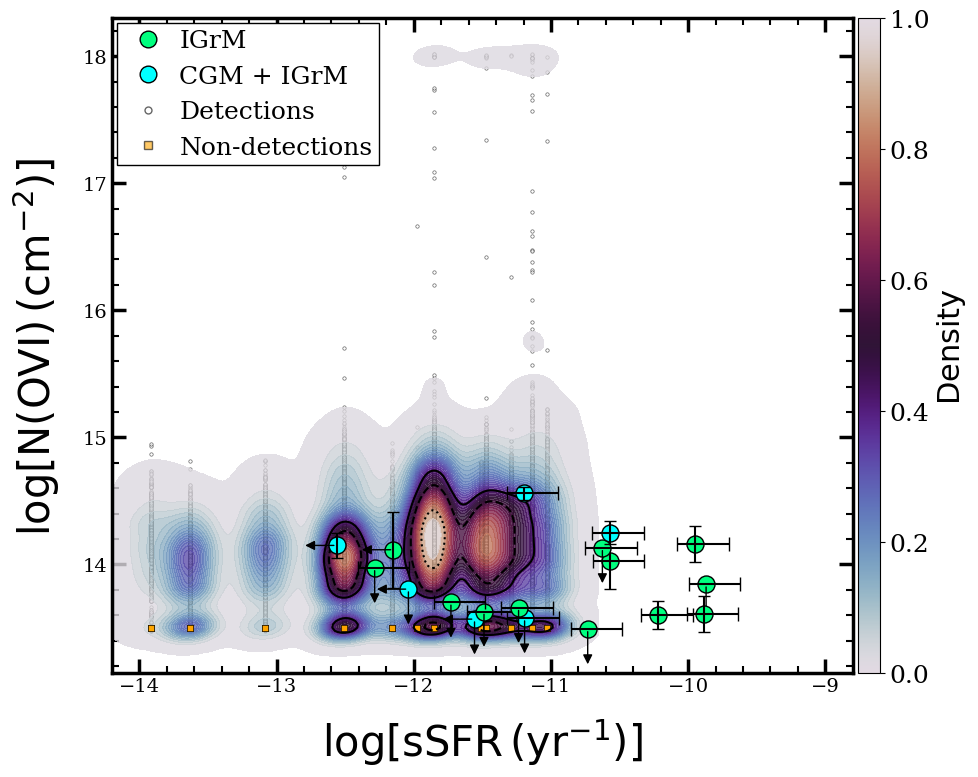

In [20]:
#!/usr/bin/env python3
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D

# ---------------------------
# Paths and Constants
# ---------------------------
base_dir = '../../Grad School/MgII_TNG_Project/Primary Project/Trident Codes/TNG_50_z_0.1_groups/revised_final'
halo_file_path = '../TNG50_fitting_results/TNG_halos.txt'
fitting_dir = '../TNG50_fitting_results/fitting_combined_features_grp_only'
galaxy_cat_dir = '../TNG50_fitting_results/galaxy_cats'
full_sample_path = '../COS_IGrM_Data/Group_Sightline_Data.txt'
plotting_data_path = '../COS_IGrM_Data/Plotting_data_subset.txt'

z = 0.1                    # Redshift
a = 1 / (1 + z)            # Scale factor
h = 0.6774                 # Hubble parameter
box_size = 35000           # Simulation box size

# Map group index to sequential group numbering
grp_index_to_group_mapping = {
    7: 0, 8: 1, 9: 2, 10: 3, 11: 4, 12: 5, 13: 6, 15: 7,
    17: 8, 18: 9, 19: 10, 20: 11, 22: 12, 24: 13
}

# ---------------------------
# Load Halo Data
# ---------------------------
halo_data = pd.read_csv(halo_file_path, sep='|', skipinitialspace=True)
halo_data.columns = halo_data.columns.str.strip()
halo_data['GroupPos_x'] = pd.to_numeric(halo_data['GroupPos_x(𝑐𝑘𝑝𝑐/ℎ)'], errors='coerce')
halo_data['GroupPos_y'] = pd.to_numeric(halo_data['GroupPos_x(𝑐𝑘𝑝𝑐/ℎ)'], errors='coerce')

# ---------------------------
# Helper Function: Cyclic Correction
# ---------------------------
def apply_cyclic_condition(ray_coord, galaxy_coord, box_size):
    diff = np.abs(galaxy_coord - ray_coord)
    if diff > box_size / 2:
        if galaxy_coord > ray_coord:
            galaxy_coord -= box_size
        else:
            galaxy_coord += box_size
    return galaxy_coord

# ---------------------------
# Initialize Arrays for Simulation Results
# ---------------------------
impact_params_detections = []
n_ovi_detections = []
log_ssfr_values = []  # log10(sSFR) for the nearest galaxy for each detection

impact_params_non_detections = []
n_ovi_non_detections = []
log_ssfr_values_non_detections = []  # for non-detections

# ---------------------------
# Loop Through Groups and Process Data
# ---------------------------
for grp_index in tqdm(grp_index_to_group_mapping.keys()):
    group_number = grp_index_to_group_mapping[grp_index]

    # Load ray data
    ray_file = os.path.join(base_dir, f"integral_TNG50-1_z0.1_n300d2-sample_localized_OVInumdens_{group_number}-of-14.hdf5")
    if not os.path.exists(ray_file):
        print(f"File not found: {ray_file}")
        continue
    with h5py.File(ray_file, 'r') as f:
        ray_positions = f['ray_pos'][:]

    # Load fitting results
    fitting_file = os.path.join(fitting_dir, f"group_{group_number}_combined_features.txt")
    if not os.path.exists(fitting_file):
        print(f"File not found: {fitting_file}")
        continue
    fitting_data = pd.read_csv(fitting_file, sep='|', skipinitialspace=True)
    fitting_data.columns = fitting_data.columns.str.strip()
    detected_data = fitting_data[~fitting_data['dN'].isna()]
    non_detected_data = fitting_data[fitting_data['dN'].isna()]

    # Load galaxy catalog
    galaxy_file = os.path.join(galaxy_cat_dir, f"group_{grp_index}_galaxy_catalog_converted.txt")
    if not os.path.exists(galaxy_file):
        print(f"Galaxy catalog not found: {galaxy_file}")
        continue
    galaxy_data = pd.read_csv(galaxy_file, sep='|', skipinitialspace=True)
    galaxy_data.columns = galaxy_data.columns.str.strip()
    galaxy_positions = galaxy_data[['SubhaloPos_0', 'SubhaloPos_1']].values
    galaxy_sfr = galaxy_data['SubhaloSFR'].values
    galaxy_stellar_mass = galaxy_data['SubhaloMassType_4'].values  # in 10^10 M_sun/h
    galaxy_stellar_mass_physical = galaxy_stellar_mass * 1e10 / h  # in physical M_sun

    # Process detections: nearest galaxy sSFR and impact parameter
    for sightline_id, log_n in zip(detected_data['Sightline'], detected_data['N']):
        ray_x, ray_y = ray_positions[sightline_id, :2]
        corrected_positions = np.array([
            [apply_cyclic_condition(ray_x, gx, box_size), apply_cyclic_condition(ray_y, gy, box_size)]
            for gx, gy in galaxy_positions
        ])
        distances = np.sqrt((corrected_positions[:, 0] - ray_x)**2 + (corrected_positions[:, 1] - ray_y)**2)
        nearest_distance = np.min(distances) * a / h  # in kpc
        nearest_idx = np.argmin(distances)
        nearest_sfr = galaxy_sfr[nearest_idx]
        nearest_mass = galaxy_stellar_mass_physical[nearest_idx]
        if nearest_mass > 0:
            ssfr = nearest_sfr / nearest_mass
            log_ssfr = np.log10(ssfr) if ssfr > 0 else -np.inf
            impact_params_detections.append(nearest_distance)
            n_ovi_detections.append(log_n)
            log_ssfr_values.append(log_ssfr)

    # Process non-detections similarly
    for sightline_id, log_n in zip(non_detected_data['Sightline'], non_detected_data['N']):
        ray_x, ray_y = ray_positions[sightline_id, :2]
        corrected_positions = np.array([
            [apply_cyclic_condition(ray_x, gx, box_size), apply_cyclic_condition(ray_y, gy, box_size)]
            for gx, gy in galaxy_positions
        ])
        distances = np.sqrt((corrected_positions[:, 0] - ray_x)**2 + (corrected_positions[:, 1] - ray_y)**2)
        nearest_distance = np.min(distances) * a / h  # in kpc
        nearest_idx = np.argmin(distances)
        nearest_sfr = galaxy_sfr[nearest_idx]
        nearest_mass = galaxy_stellar_mass_physical[nearest_idx]
        if nearest_mass > 0:
            ssfr = nearest_sfr / nearest_mass
            log_ssfr = np.log10(ssfr) if ssfr > 0 else -np.inf
            impact_params_non_detections.append(nearest_distance)
            log_ssfr_values_non_detections.append(log_ssfr)
            n_ovi_non_detections.append(log_n)
    # For non-detections, force N(OVI) to a constant (e.g., 13.5)
    n_ovi_non_detections = [13.5] * len(log_ssfr_values_non_detections)

# Convert results to numpy arrays
impact_params_detections = np.array(impact_params_detections)
n_ovi_detections = np.array(n_ovi_detections)
log_ssfr_values = np.array(log_ssfr_values)

impact_params_non_detections = np.array(impact_params_non_detections)
n_ovi_non_detections = np.array(n_ovi_non_detections)
log_ssfr_values_non_detections = np.array(log_ssfr_values_non_detections)

# ---------------------------
# Filter: Keep only detections with log(sSFR) > -11
# ---------------------------
mask_det = log_ssfr_values > -11
mask_non_det = log_ssfr_values_non_detections > -11

impact_params_detections = impact_params_detections[mask_det]
n_ovi_detections = n_ovi_detections[mask_det]
log_ssfr_values = log_ssfr_values[mask_det]

impact_params_non_detections = impact_params_non_detections[mask_non_det]
n_ovi_non_detections = n_ovi_non_detections[mask_non_det]
log_ssfr_values_non_detections = log_ssfr_values_non_detections[mask_non_det]

# ---------------------------
# Plot: N(OVI) vs. Impact Parameter for absorbers with log(sSFR) > -11
# ---------------------------
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot for detections
ax.scatter(
    impact_params_detections, n_ovi_detections,
    color='white', s=6, alpha=0.6,
    edgecolor='black', linewidth=0.5,
    marker='o', label='Detections', zorder=0
)

# Scatter plot for non-detections
ax.scatter(
    impact_params_non_detections, n_ovi_non_detections,
    color='orange', s=8, alpha=0.6,
    edgecolor='black', linewidth=0.5,
    marker='s', label='Non-detections', zorder=3
)

# KDE plot for detections
kde = sns.kdeplot(
    x=impact_params_detections, y=n_ovi_detections, fill=True,
    cmap="twilight", levels=40, thresh=0.002, alpha=0.8, ax=ax, rasterized=True, zorder=2
)
sns.kdeplot(
    x=impact_params_detections, y=n_ovi_detections, levels=[0.5, 0.68, 0.95],
    color="black", linewidths=1.5, ax=ax, linestyles=["solid", "dashed", "dotted"], zorder=3
)

# Add Colorbar for KDE
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
kde_min, kde_max = kde.collections[0].get_clim()
norm = mcolors.Normalize(vmin=kde_min, vmax=kde_max)
sm = cm.ScalarMappable(cmap="twilight", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_label(r'$\mathrm{Density}$', fontsize=22)
cbar.ax.tick_params(labelsize=18)

# ---------------------------
# Overlay Observational Data (if available)
# ---------------------------
full_sample_df = pd.read_csv(full_sample_path, sep='|', comment='#', engine='python')
plotting_data_df = pd.read_csv(plotting_data_path, sep='\s+', comment='#', engine='python')
full_sample_df = full_sample_df.loc[:, ~full_sample_df.columns.str.contains('^unnamed', case=False)]
plotting_data_df = plotting_data_df.loc[:, ~plotting_data_df.columns.str.contains('^unnamed', case=False)]
full_sample_df.columns = full_sample_df.columns.str.strip().str.lower()
plotting_data_df.columns = plotting_data_df.columns.str.strip().str.lower()
full_sample_df['group'] = full_sample_df['group'].str.strip().str.upper()
plotting_data_df['group'] = plotting_data_df['group'].str.strip().str.upper()
print("Unique values in full_sample_df['group']:", full_sample_df['group'].unique())
print("Unique values in plotting_data_df['group']:", plotting_data_df['group'].unique())
merged_df = pd.merge(full_sample_df, plotting_data_df, on='group', how='inner')
print("Unique values in merged_df['subset']:", merged_df['subset'].unique())
print("Number of rows in merged_df:", len(merged_df))

# IMPORTANT: Check if the merged DataFrame contains the column 'sSFR'
if 'sSFR' not in merged_df.columns:
    print("ERROR: Column 'sSFR' not found in merged_df. Available columns:", merged_df.columns.tolist())
    # Optionally, you can rename an existing column to 'sSFR' here if needed.
else:
    merged_df['sSFR'] = merged_df['sSFR'].str.strip()  # Normalize, if needed

    # Plot observational data
    x_err_right = 0.25
    x_err_left_detection = x_err_right / 2
    for idx, row in merged_df.iterrows():
        log_ssfr_obs = row['sSFR']
        n_ovi_obs = row['n_ovi']
        sSFR_lim = row['sSFR_lim']
        N_lim = row['n_lim']
        N_OVI_err_low = row['n_ovi_err_low']
        N_OVI_err_high = row['n_ovi_err_high']
        Subset = row['subset']
        marker_color = 'springgreen' if Subset == 'I' else 'cyan'
        label = 'IGrM' if Subset == 'I' else 'CGM + IGrM'
        ax.scatter(log_ssfr_obs, n_ovi_obs, marker='o', color=marker_color, edgecolor='black',
                   s=150, zorder=3)
        if (not sSFR_lim) and (not N_lim):
            horz_err = [[x_err_left_detection], [x_err_right]]
            ax.errorbar(log_ssfr_obs, n_ovi_obs, xerr=horz_err, fmt='none',
                        ecolor='black', capsize=5, zorder=3)
            ax.errorbar(log_ssfr_obs, n_ovi_obs,
                        yerr=[[N_OVI_err_low], [N_OVI_err_high]], fmt='none',
                        ecolor='black', capsize=4, zorder=3)
        elif sSFR_lim and (not N_lim):
            ax.errorbar(log_ssfr_obs, n_ovi_obs,
                        yerr=[[N_OVI_err_low], [N_OVI_err_high]], fmt='none',
                        ecolor='black', capsize=4, zorder=3)
            ax.annotate('',
                        xy=(log_ssfr_obs - x_err_right, n_ovi_obs),
                        xytext=(log_ssfr_obs, n_ovi_obs),
                        arrowprops=dict(facecolor='black', arrowstyle='-|>',
                                        lw=1, alpha=1, edgecolor='black'),
                        zorder=3)
        elif (not sSFR_lim) and N_lim:
            horz_err = [[x_err_left_detection], [x_err_right]]
            ax.errorbar(log_ssfr_obs, n_ovi_obs, xerr=horz_err, fmt='none',
                        ecolor='black', capsize=5, zorder=3)
            ax.annotate('',
                        xy=(log_ssfr_obs, n_ovi_obs - 0.3),
                        xytext=(log_ssfr_obs, n_ovi_obs),
                        arrowprops=dict(facecolor='black', arrowstyle='-|>',
                                        lw=1, alpha=1, edgecolor='black'),
                        zorder=3)
        else:
            ax.annotate('',
                        xy=(log_ssfr_obs - x_err_right, n_ovi_obs),
                        xytext=(log_ssfr_obs, n_ovi_obs),
                        arrowprops=dict(facecolor='black', arrowstyle='-|>',
                                        lw=1, alpha=1, edgecolor='black'),
                        zorder=3)
            ax.annotate('',
                        xy=(log_ssfr_obs, n_ovi_obs - 0.3),
                        xytext=(log_ssfr_obs, n_ovi_obs),
                        arrowprops=dict(facecolor='black', arrowstyle='-|>',
                                        lw=1, alpha=1, edgecolor='black'),
                        zorder=3)
        print('---')

# ---------------------------
# Axis Labels, Limits, and Ticks
# ---------------------------
ax.set_xlabel(r'$\rho_\mathrm{cg} \, (\mathrm{kpc})$', fontsize=32, labelpad=15)
ax.set_ylabel(r'$\log[\mathrm{N(OVI)} \, (\mathrm{cm^{-2}})]$', fontsize=30, labelpad=15)
ax.set_xlim(-1, 1010)
ax.set_ylim(13.2, 18.1)
ax.tick_params(axis='both', which='major', direction='in', width=2, length=7)
ax.spines['top'].set_linewidth(2.5)
ax.spines['right'].set_linewidth(2.5)
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
ax.tick_params(axis='both', which='major', direction='in', length=10, width=2.5, top=True, right=True)
ax.tick_params(axis='both', which='minor', direction='in', length=5, width=1.5, top=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

legend_elements = [
    Line2D([0], [0], marker='o', color='springgreen', label='IGrM', markersize=12,
           markeredgecolor='black', linestyle='none'),
    Line2D([0], [0], marker='o', color='cyan', label='CGM + IGrM', markersize=12,
           markeredgecolor='black', linestyle='none'),
    Line2D([0], [0], marker='o', color='white', label='Detections', markersize=5,
           markeredgecolor='black', linestyle='none', alpha=0.6),
    Line2D([0], [0], marker='s', color='orange', label='Non-detections', markersize=6,
           markeredgecolor='black', linestyle='none', alpha=0.6)
]

ax.legend(handles=legend_elements, frameon=True, framealpha=1, edgecolor='black',
          fancybox=False, shadow=False, borderpad=0.25, borderaxespad=0.2,
          handletextpad=0.25, fontsize=18, loc='upper right')

plt.tight_layout()
output_dir = '../TNG50_fitting_results/Plots_gal_removed'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.savefig(os.path.join(output_dir, 'N_OVI_vs_Impact_Param_obs_ge_11.pdf'), dpi=200)
plt.show()